# PhreeqcRM BMI Python Example

This notebook demonstrates how to use the Python wrappers included with the PHREEQC Reaction Module (PhreeqcRM) to couple the PHREEQC geochemical reaction model to a simple 1D advection model using the [Basic Model Interface (BMI)](https://bmi.readthedocs.io/en/stable/).

PhreeqcRM is described in this publication:
- Parkhurst, D.L. and Wissmeier, L., 2015. [PhreeqcRM: A reaction module for transport simulators based on the geochemical model PHREEQC](https://pubs.usgs.gov/publication/70189910). *Advances in Water Resources*, 83, pp.176-189.
  - Full Text PDF: https://water.usgs.gov/water-resources/software/VS2DRTI/ParkhurstWissmeier2015.pdf


This demonstration is designed around the PHREEQC Example 11: Transport and Cation Exchange provided in the [PHREEQC Version 3 Manual](https://pubs.usgs.gov/tm/06/a43/pdf/tm6-A43.pdf).

by Scott Charlton, Shanna Rucker Blount, Anthony Aufdenkampe

# Installation and Setup

PhreeqcRM and it's Python wrapper can be installed into a conda virtual environment by running the following command:
```shell
conda install phreeqcrm
```

Alternately, a custom conda virtual environment can be created using the `environment.yml` file included in this folder.

## Python Imports

In [1]:
import phreeqcrm
import numpy as np
import matplotlib.pyplot as plt

# Docs for PhreeqcRM modules and functions

PhreeqcRM has three modules:
- [**PhreeqcRM**](https://usgs-coupled.github.io/phreeqcrm/classPhreeqcRM.html): a geochemical reaction module for reactive-transport
simulators. Based on IPhreeqc, it allows access to all
PHREEQC reaction capabilities.
- [**BMIPhreeqcRM**](https://usgs-coupled.github.io/phreeqcrm/classBMIPhreeqcRM.html): a subclass of PhreeqcRM that adds BMI standard functions.
- [**YAMLPhreeqcRM**](https://usgs-coupled.github.io/phreeqcrm/classYAMLPhreeqcRM.html): A helper class to programmatically write a YAML configuration file for PhreeqcRM.

These modules and their functions are documented in the C++ code and compiled by the Doxygen document generator at https://usgs-coupled.github.io/phreeqcrm.

In [2]:
# Explore phreeqcrm namespace
dir(phreeqcrm)

['BMIPhreeqcRM',
 'BoolVector',
 'DoubleVector',
 'IRM_BADINSTANCE',
 'IRM_BADVARTYPE',
 'IRM_FAIL',
 'IRM_INVALIDARG',
 'IRM_INVALIDCOL',
 'IRM_INVALIDROW',
 'IRM_OK',
 'IRM_OUTOFMEMORY',
 'IntVector',
 'PhreeqcRM',
 'State',
 'StringVector',
 'YAMLPhreeqcRM',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_phreeqcrm',
 'phreeqcrm',
 'yamlphreeqcrm']

In [3]:
# Explore phreeqcrm documentation
phreeqcrm.YAMLPhreeqcRM.YAMLSpeciesConcentrations2Module?

Signature:
phreeqcrm.YAMLPhreeqcRM.YAMLSpeciesConcentrations2Module(
    self,
    species_conc,
)
Docstring:
Inserts data into the YAML document for the PhreeqcRM method SpeciesConcentrations2Module.

When the YAML document is written to file it can be processed by the method InitializeYAML to
initialize a PhreeqcRM instance. SpeciesConcentrations2Module sets solution concentrations in 
the reaction cells based on the vector of aqueous species concentrations (@a species_conc).
This method is intended for use with multicomponent-diffusion transport calculations, and 
SetSpeciesSaveOn must be set to true.  The list of aqueous species is determined by 
FindComponents and includes all aqueous species that can be made from the set of components.
The method determines the total concentration of a component by summing the molarities of the 
individual species times the stoichiometric coefficient of the element in each species.
Solution compositions in the reaction cells are updated with thes

In [4]:
help(phreeqcrm.YAMLPhreeqcRM.YAMLSpeciesConcentrations2Module)

Help on function YAMLSpeciesConcentrations2Module in module phreeqcrm.yamlphreeqcrm:

YAMLSpeciesConcentrations2Module(self, species_conc)
    Inserts data into the YAML document for the PhreeqcRM method SpeciesConcentrations2Module.
    
    When the YAML document is written to file it can be processed by the method InitializeYAML to
    initialize a PhreeqcRM instance. SpeciesConcentrations2Module sets solution concentrations in 
    the reaction cells based on the vector of aqueous species concentrations (@a species_conc).
    This method is intended for use with multicomponent-diffusion transport calculations, and 
    SetSpeciesSaveOn must be set to true.  The list of aqueous species is determined by 
    FindComponents and includes all aqueous species that can be made from the set of components.
    The method determines the total concentration of a component by summing the molarities of the 
    individual species times the stoichiometric coefficient of the element in each speci

# Create a configuration YAML file for PHREEQC Example 11

We will use the `phreeqcrm.YAMLPhreeqcRM()` module to create a configuration file as input to `phreeqcrm.BMIPhreeqcRM.initialize()`. This is the easiest way to run the Reaction Module.

## Initialize YAML file and set grid size

In [5]:
# Create YAMLPhreeqcRM document
yrm = phreeqcrm.YAMLPhreeqcRM()

# Number of cells
nxyz = 40                 
    # nxyz is the number of grid cells in the user's model

# Set GridCellCount
yrm.YAMLSetGridCellCount(nxyz)  
    # Number of cells for the PhreeqcRM instance

## Set Properties

In [6]:
yrm.YAMLSetErrorHandlerMode(1)   
    # 0 (default), return to calling program with an error return code; 
    # 1, throw an exception; 2, attempt to exit gracefully
yrm.YAMLSetComponentH2O(False)              
    # True (default), excess H, excess O, and water are included in the 
    #   component list (require less accuracy in transport); 
    # False, total H and O are included in the component list (requires 
    #   transportresults to be accurate to eight or nine significant 
    #   digits)
yrm.YAMLSetRebalanceFraction(0.5)           
    # 0.5 (default); 
    # 0, eliminate load rebalancing; 
    # 1, maximum load rebalancing setting; 
    # Less than 1 recommended to avoid too many cells transferred at one 
    #   iteration
yrm.YAMLSetRebalanceByCell(True)            
    # True (default), individual cell times are used in rebalancing; 
    # False, average times are used in rebalancing
yrm.YAMLUseSolutionDensityVolume(False)     
    # True, use solution density and volume as calculated by PHREEQC; 
    # False, use solution density set by SetDensityUser and the volume 
    #   determined by the product of  SetSaturationUser, SetPorosity, 
    #   and SetRepresentativeVolume
yrm.YAMLSetPartitionUZSolids(False)         
    # True, the fraction of solids and gases available for reaction is 
    #   equal to the saturation; 
    # False (default), all solids and gases are reactive regardless of 
    #   saturation

## Set Units

In [7]:
# Set concentration units
yrm.YAMLSetUnitsSolution(2)           
    # 1, mg/L; 2, mol/L; 3, kg/kgs
yrm.YAMLSetUnitsPPassemblage(1)       
    # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
yrm.YAMLSetUnitsExchange(1)           
    # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
yrm.YAMLSetUnitsSurface(1)            
    # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
yrm.YAMLSetUnitsGasPhase(1)           
    # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
yrm.YAMLSetUnitsSSassemblage(1)       
    # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
yrm.YAMLSetUnitsKinetics(1)           
    # 0, mol/L cell; 1, mol/L water; 2 mol/L rock


# Set conversion from seconds to user units (days);
#   Only affects one print statement
time_conversion = 1.0 / 86400.0
yrm.YAMLSetTimeConversion(time_conversion)      
    # Factor to convert seconds to user time units

## Set Initial Conditions

In [8]:
# Set representative volume
rv = [1] * nxyz                                 
yrm.YAMLSetRepresentativeVolume(rv)             
    # Representative volumes, in liters, of each reaction cell as an 
    #   array of size nxyz. Default is 1.0 liter.

# Set initial density
density = [1.0] * nxyz
yrm.YAMLSetDensityUser(density)                 
    # Density for each reaction cell as an array of size nxyz

# Set initial porosity
por = [0.2] * nxyz
yrm.YAMLSetPorosity(por)                        
    # Porosity, unitless, for each reaction cell as an array of size 
    #   nxyz

# Set initial saturation
sat = [1] * nxyz
yrm.YAMLSetSaturationUser(sat)                  
    # Saturation fraction for each reaction cell ranging from 0 to 1 as 
    #   an array of size nxyz

## Load Database and Run Input File

In [9]:
# Load database
yrm.YAMLLoadDatabase("phreeqc.dat")             
    # String containing the database name for all IPhreeqc 
    #   instances--workers, InitialPhreeqc, and Utility

# Run file to define solutions and reactants for initial conditions, 
#   selected output
workers = True             
    # Worker instances do the reaction calculations for transport
initial_phreeqc = True     
    # InitialPhreeqc instance accumulates initial and boundary 
    #   conditions
utility = True             
    # Utility instance is available for processing
chemistry_name = "advect.pqi"
yrm.YAMLRunFile(workers, initial_phreeqc, utility, chemistry_name)        
    # YAMLRunFile runs a PHREEQC input file. The first three arguments 
    #   determine which IPhreeqc instances will run the file


## Clear contents of Workers and Utility

In [10]:
initial_phreeqc = False    
    # False Indicates InitialPhreeqc will not run the string
input = "DELETE; -all"     
    # String containing PHREEQC input that clears contents for the 
    #   instances that run
yrm.YAMLRunString(workers, initial_phreeqc, utility, input)       
    # YAMLRunString runs a PHREEQC input string. The first three 
    #   arguments determine which IPhreeqc instances will run the string
output_vars = "AddOutputVars"                       
    # A string value that includes or excludes variables from 
    #   GetOutputVarNames, GetValue, and other BMI methods
include_vars = "true"                               
    # A string value that can be "false", "true", or a list of items to 
    #   be included as accessible variables
yrm.YAMLAddOutputVars(output_vars, include_vars)    
    # AddOutputVars allows selection of sets of output variables that 
    #   are available through the BMI method GetValue

## Find Components and Transfer Definitions

In [11]:
# Determine number of components to transport
yrm.YAMLFindComponents()    
    # YAMLFindComponents accumulates a list of elements that have been 
    #   defined in a solution or any other reactant (EQUILIBRIUM_PHASE, 
    #   KINETICS, and others). The list is the set of components that 
    #   needs to be transported

# initial solutions
initial_solutions = [1] * nxyz
yrm.YAMLInitialSolutions2Module(initial_solutions)      
    # SOLUTION definitions, as an array of size nxyz, from the 
    #   InitialPhreeqc instance to be transferred to the reaction-module
    #   workers

# initial exchanges
initial_exchanges = [1] * nxyz
yrm.YAMLInitialExchanges2Module(initial_exchanges)      
    # EXCHANGE definitions, as an array of size nxyz, from the 
    #   InitialPhreeqc instance to be transferred to the reaction-module
    #   workers

## Write YAML File

In [12]:
yrm.WriteYAMLDoc("ex11-advect.yaml")        
    # String containing file name where YAML document will be written

# Create the Simple 1D Advection Model
Define a function to implement a simple 1-dimensional advection model.

In [13]:
def advect(c: np.ndarray, bc_conc: np.ndarray, ncomps: int, nxyz: int):
    # Advect
    for i in range(nxyz - 1, 0, -1):
        for j in range(ncomps):
            c[j * nxyz + i] = c[j * nxyz + i - 1]       # component j
    
    # Cell zero gets boundary condition
    for j in range(ncomps):
        c[j * nxyz] = bc_conc[j]                        # component j

# Couple PHREEQC Geochemical Model with Simple Advection Model

## Initialize PhreeqcRM with YAML
Using config YAML file created above for PHREEQC Example 11.

In [14]:
rm = phreeqcrm.BMIPhreeqcRM()
rm.initialize("ex11-advect.yaml")

In [15]:
# Explore PhreeqcRM model configuration
print(
    '\n',
    rm.get_value_ptr("ComponentCount")[0],
    rm.GetComponents(), 
    '\n',
    rm.GetExchangeSpeciesCount(),
    rm.GetExchangeSpecies(),
    '\n',
    rm.get_input_var_names(),
    '\n',
    rm.get_pointable_var_names(),
    '\n',
    rm.get_output_var_names(),
)


 8 ('H', 'O', 'Charge', 'Ca', 'Cl', 'K', 'N', 'Na') 
 4 ('CaX2', 'KX', 'NaX', 'X-') 
 ('Concentrations', 'DensityUser', 'FilePrefix', 'NthSelectedOutput', 'SaturationUser', 'Time', 'TimeStep', 'Porosity', 'Pressure', 'SelectedOutputOn', 'Temperature') 
 ('ComponentCount', 'Concentrations', 'DensityCalculated', 'Gfw', 'GridCellCount', 'SaturationCalculated', 'SolutionVolume', 'Time', 'TimeStep', 'Porosity', 'Pressure', 'SelectedOutputOn', 'Temperature', 'Viscosity') 
 ('ComponentCount', 'Components', 'Concentrations', 'DensityCalculated', 'ErrorString', 'FilePrefix', 'Gfw', 'GridCellCount', 'SaturationCalculated', 'SelectedOutput', 'SelectedOutputColumnCount', 'SelectedOutputCount', 'SelectedOutputRowCount', 'SolutionVolume', 'Time', 'TimeStep', 'CurrentSelectedOutputUserNumber', 'Porosity', 'Pressure', 'SelectedOutputOn', 'Temperature', 'Viscosity', 'exchange_total_molality_X', 'exchange_X_species_log_molality_CaX2', 'exchange_X_species_log_molality_KX', 'exchange_X_species_log_molali

In [16]:
# Save number of components for use later
ncomps = rm.get_value_ptr("ComponentCount")[0]  
    # eight components: ['H', 'O', 'Charge', 'Ca', 'Cl', 'K', 'N', 'Na']
ncomps

8

In [17]:
# Save list of outputs for use later
output_var_names = rm.get_output_var_names()
output_var_names

('ComponentCount',
 'Components',
 'Concentrations',
 'DensityCalculated',
 'ErrorString',
 'FilePrefix',
 'Gfw',
 'GridCellCount',
 'SaturationCalculated',
 'SelectedOutput',
 'SelectedOutputColumnCount',
 'SelectedOutputCount',
 'SelectedOutputRowCount',
 'SolutionVolume',
 'Time',
 'TimeStep',
 'CurrentSelectedOutputUserNumber',
 'Porosity',
 'Pressure',
 'SelectedOutputOn',
 'Temperature',
 'Viscosity',
 'exchange_total_molality_X',
 'exchange_X_species_log_molality_CaX2',
 'exchange_X_species_log_molality_KX',
 'exchange_X_species_log_molality_NaX',
 'exchange_X_species_log_molality_X-',
 'solution_alkalinity',
 'solution_charge_balance',
 'solution_ionic_strength',
 'solution_pe',
 'solution_percent_error',
 'solution_ph',
 'solution_specific_conductance',
 'solution_total_molality_Ca',
 'solution_total_molality_Cl',
 'solution_total_molality_H',
 'solution_total_molality_H(0)',
 'solution_total_molality_H(1)',
 'solution_total_molality_K',
 'solution_total_molality_N',
 'solutio

In [18]:
# Confirm grid size
assert nxyz == rm.get_value_ptr("GridCellCount")[0] 
    # AssertionError raised if nxyz does not equal GridCellCount
nxyz

40

## Set Initial Concentrations and Boundary Conditions

In [19]:
# Get initial concentrations from phreeqcrm
c = rm.get_value_ptr("Concentrations") 
    # One-dimensional array with 320 indices (40 nxyz x 8 ncomps) 
    # Includes 40 concentration values for each of the eight components
c.shape

(320,)

In [20]:
# Set boundary condition
bc1 = [0]           # solution 0 from Initial IPhreeqc instance

bc_conc = rm.InitialPhreeqc2Concentrations(bc1) 
    # One-dimensional array with 8 indices
bc_conc.shape

(8,)

## Run Transient Loop through All Timesteps

In [21]:
# set number of time steps
nsteps = 100

In [22]:
# Pre-Allocate Python Arrays for Outputs

# Create empty NumPy arrays for molality totals (random values set as 
#   initial values for each of the 40 indices)
solution_total_molality_Cl = np.empty((nxyz,), dtype=float)
solution_total_molality_Na = np.empty((nxyz,), dtype=float)
solution_total_molality_K  = np.empty((nxyz,), dtype=float)
solution_total_molality_Ca = np.empty((nxyz,), dtype=float)

exchange_X_species_log_molality_Xminus  = np.empty((nxyz,), dtype=float)
exchange_X_species_log_molality_NaX  = np.empty((nxyz,), dtype=float)
exchange_X_species_log_molality_KX  = np.empty((nxyz,), dtype=float)
exchange_X_species_log_molality_CaX2  = np.empty((nxyz,), dtype=float)


# Create empty NumPy arrays for components - will store molality results
#   for each time step
Na = np.empty((nsteps,nxyz), dtype=float)
Cl = np.empty((nsteps,nxyz), dtype=float)
K = np.empty((nsteps,nxyz), dtype=float)
Ca = np.empty((nsteps,nxyz), dtype=float)

NaX = np.empty((nsteps,nxyz), dtype=float)
Xminus = np.empty((nsteps,nxyz), dtype=float)
KX = np.empty((nsteps,nxyz), dtype=float)
CaX2 = np.empty((nsteps,nxyz), dtype=float)

# Create empty NumPy array for pore volumes
por_volumes = np.empty((nsteps), dtype=float)

In [23]:
# Print column headers for outputs
print(f"step Na Cl K Ca NaX X- KX CaX2 Pore_vol")

# Loop through each time step
for s in range(nsteps):
    # Advance phreeqcrm model by a single time step
    rm.update()

    # Run advection model
    advect(c, bc_conc, ncomps, nxyz)

    # Update phreeqcrm concentrations based on advection model run
    rm.set_value("Concentrations", c)

    # Retrieve aqueous phase species molality results from phreeqcrm
    solution_total_molality_Cl = rm.get_value("solution_total_molality_Cl", 
                                              solution_total_molality_Cl)
    solution_total_molality_Na = rm.get_value("solution_total_molality_Na", 
                                              solution_total_molality_Na)
    solution_total_molality_K  = rm.get_value("solution_total_molality_K",  
                                              solution_total_molality_K)
    solution_total_molality_Ca = rm.get_value("solution_total_molality_Ca", 
                                              solution_total_molality_Ca)
    
    # Retrieve solid phase exchange species results from phreeqcrm
    exchange_X_species_log_molality_Xminus = \
        rm.get_value("exchange_X_species_log_molality_X-", 
                     exchange_X_species_log_molality_Xminus)
    exchange_X_species_log_molality_NaX = \
        rm.get_value("exchange_X_species_log_molality_NaX", 
                     exchange_X_species_log_molality_NaX)
    exchange_X_species_log_molality_KX = \
        rm.get_value("exchange_X_species_log_molality_KX", 
                     exchange_X_species_log_molality_KX)
    exchange_X_species_log_molality_CaX2 = \
        rm.get_value("exchange_X_species_log_molality_CaX2", 
                     exchange_X_species_log_molality_CaX2)


    step = s + 1    # Advance step by one

    # Calculate pore volume
    por_vol = (step + 0.5) / 40

    # Store last molality concentration result in array index 
    #   corresponding to current time step
    Na[s,:] = solution_total_molality_Na
    Cl[s,:] = solution_total_molality_Cl
    K[s,:]  = solution_total_molality_K
    Ca[s,:] = solution_total_molality_Ca

    NaX[s,:] = exchange_X_species_log_molality_NaX
    Xminus[s,:] = exchange_X_species_log_molality_Xminus
    KX[s,:] = exchange_X_species_log_molality_KX
    CaX2[s,:] = exchange_X_species_log_molality_CaX2

    # Store pore volume result in array index corresponding to current 
    #   time step
    por_volumes[s] = por_vol

    # Print results for current time step at the last grid cell
    cell = nxyz - 1 # Equals 39 (last index in concentration array)
    print(f"{step} {Na[s, cell]:.4e} {Cl[s, cell]:.4e} {K[s, cell]:.4e} "
          f"{Ca[s, cell]:.4e} {NaX[s, cell]:.4e} {Xminus[s, cell]:.4e} "
          f"{KX[s, cell]:.4e} {CaX2[s, cell]:.4e} {por_volumes[s,]:.4e}")

step Na Cl K Ca NaX X- KX CaX2 Pore_vol
1 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 -3.9591e+00 2.6985e+00 -3.9581e+00 -9.9990e+01 3.7500e-02
2 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 -3.9591e+00 2.6985e+00 -3.9581e+00 -9.9990e+01 6.2500e-02
3 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 -3.9591e+00 2.6985e+00 -3.9581e+00 -9.9990e+01 8.7500e-02
4 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 -3.9591e+00 2.6985e+00 -3.9581e+00 -9.9990e+01 1.1250e-01
5 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 -3.9591e+00 2.6985e+00 -3.9581e+00 -9.9990e+01 1.3750e-01
6 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 -3.9591e+00 2.6985e+00 -3.9581e+00 -9.9990e+01 1.6250e-01
7 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 -3.9591e+00 2.6985e+00 -3.9581e+00 -9.9990e+01 1.8750e-01
8 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 -3.9591e+00 2.6985e+00 -3.9581e+00 -9.9990e+01 2.1250e-01
9 1.0000e-03 0.0000e+00 2.0000e-04 0.0000e+00 -3.9591e+00 2.6985e+00 -3.9581e+00 -9.9990e+01 2.3750e-01
10 1.0000e-03 0.0000e+00

# Plot Results

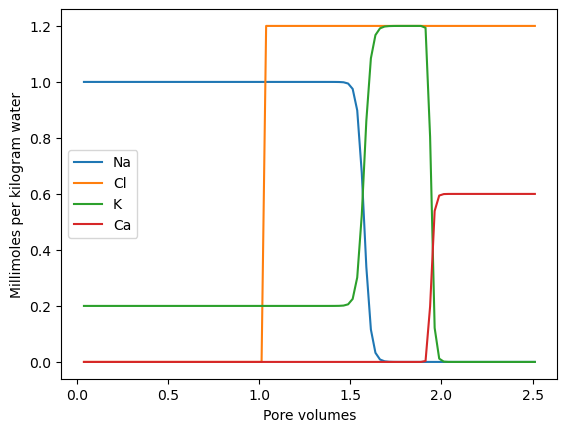

In [24]:
# Plot aqueous phase component concentration results as a function 
#   of pore volumes
fig, ax = plt.subplots()
ax.plot(por_volumes, Na[:,cell]*1000, label='Na')
ax.plot(por_volumes, Cl[:,cell]*1000, label='Cl')
ax.plot(por_volumes, K[:,cell]*1000,  label='K')
ax.plot(por_volumes, Ca[:,cell]*1000, label='Ca')
ax.set_xlabel('Pore volumes')
ax.set_ylabel('Millimoles per kilogram water')
ax.legend()
plt.show()

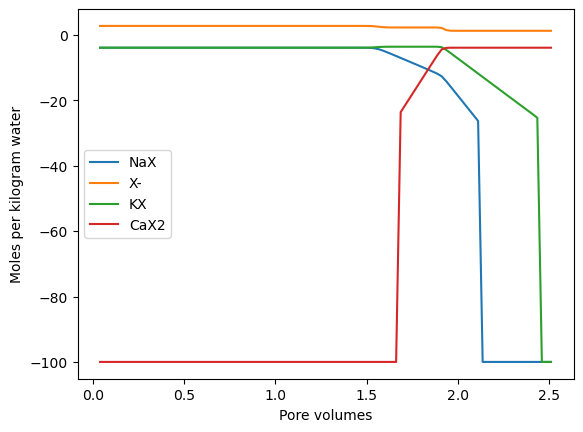

In [25]:
# Plot solid phase exchange species results
fig, ax = plt.subplots()
ax.plot(por_volumes, NaX[:,cell], label='NaX')
ax.plot(por_volumes, Xminus[:,cell], label='X-')
ax.plot(por_volumes, KX[:,cell],  label='KX')
ax.plot(por_volumes, CaX2[:,cell], label='CaX2')
ax.set_xlabel('Pore volumes')
ax.set_ylabel('Moles per kilogram water')
ax.legend()
plt.show()

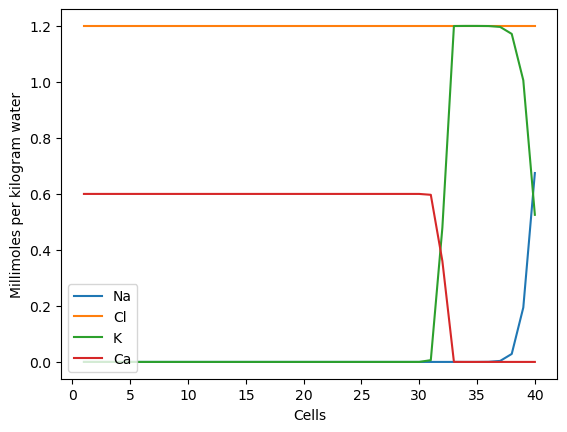

In [26]:

# Identify transition zone time steps of interest
target_step = 62  
    # 62, near when Na and K intersect for first time at last time step
    # 66, when K approaches maximum molality at last time step

cells = list(range(1, 41))  # Array from 1 to 40

# Plot aqueous phase component concentration results as a function of 
#   grid cell for a single time step
fig, ax = plt.subplots()
ax.plot(cells, Na[target_step - 1, :]*1000, label='Na')
ax.plot(cells, Cl[target_step - 1, :]*1000, label='Cl')
ax.plot(cells, K[target_step - 1, :]*1000,  label='K')
ax.plot(cells, Ca[target_step - 1, :]*1000, label='Ca')
ax.set_xlabel('Cells')
ax.set_ylabel('Millimoles per kilogram water')
ax.legend(loc='lower left')
plt.show()